In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

current_palette = sns.color_palette(("#000000",))
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(20,4)}, style='whitegrid', font='CMU Serif')

def save_fig(ax, folder, suffix, format=".pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + format)
    fig.clear()

In [3]:
df_complete = pd.DataFrame()
df_cdf = pd.DataFrame()

for client in ["1", "2", "3"]:
    # relevant file is in ./results/out-baseline[client].csv
    path = os.path.join(".", "results", "out-baseline" + client )

    df = pd.read_csv(path)


    min_t = df["send_time"].min()
    df["send_time"] = df["send_time"] - min_t
    df["recv_time"] = df["recv_time"] - min_t

    

    # cut off some stuff to shorten it to 10 minutes
    #required_length = 200 * 1e9
    required_length = 10 * 60 * 1e9
    actual_length = df["send_time"].max()
    cutoff = (actual_length - required_length) / 2

    df = df[(cutoff <= df["send_time"]) & (df["send_time"] <= actual_length - cutoff)]

    min_t = df["send_time"].min()
    df["send_time"] = df["send_time"] - min_t
    df["recv_time"] = df["recv_time"] - min_t

    print(df["send_time"].max()/1e9)
    
    other_clients = df["id"].unique()

    for other in other_clients:
        o = str(other)

        df_run = df[(df["id"] == other)]
        # create dataframe new dataframe with counts per latency per run per threshold
        df_tmp = pd.DataFrame(dict(Counter(df_run["latency"])), index=[0]).T
        # transform index into column and add other columns needed for the figure
        df_tmp.reset_index(inplace=True)
        df_tmp.insert(0, "Path", o + "-" + client)
        # set column names
        df_tmp.columns = ["Path", "Latency", "Count"]
        # calculate distribution
        df_tmp.sort_values(by="Latency", ascending=True, inplace=True)
        df_tmp["cumsum"] = df_tmp["Count"].cumsum()
        sum = df_tmp["Count"].sum()
        df_tmp["Cumulative Distribution"] = df_tmp["cumsum"] / sum
        # add to result df
        df_cdf = df_cdf.append(df_tmp)

        df_tmp2 = df_run.copy()
        df_tmp2.reset_index(inplace=True)
        df_tmp2.insert(0, "Path", o + "-" + client)

        df_tmp2["t2"] = pd.to_datetime(df_tmp2["send_time"])
        df_tmp2.sort_values(by=["t2"], inplace=True)
        df_tmp2["latency_r"] = df_tmp2.rolling('1s', min_periods=1, on="t2").median()["latency"]
        df_tmp2["latency_r_log10"] = np.log10(df_tmp2["latency_r"])
        #print(df_tmp2)
        df_tmp2.columns = ["Path", "index", "id", "packet_n", "packet_len", "Latency", "send_time", "recv_time", "t2", "latency_r", "latency_r_log10"]
        df_complete = df_complete.append(df_tmp2)

df_cdf.reset_index(inplace=True, drop=True) # optionally reset index
df_cdf

423.464790784
423.603145216
423.103320576


,Path,Latency,Count,cumsum,Cumulative Distribution
0,2-1,0.34,2,2,0.000014
1,2-1,0.35,5,7,0.000050
2,2-1,0.36,3,10,0.000071
3,2-1,0.37,2,12,0.000086
4,2-1,0.38,3,15,0.000107
...,...,...,...,...,...
7992,2-3,236.71,1,139875,0.999971
7993,2-3,237.43,1,139876,0.999979
7994,2-3,237.48,1,139877,0.999986
7995,2-3,237.76,1,139878,0.999993


In [4]:
df_complete

,Path,index,id,packet_n,packet_len,Latency,send_time,recv_time,t2,latency_r,latency_r_log10
0,2-1,0,2,0,123,5.78,0,5782016,1970-01-01 00:00:00.000000000,5.780,0.761928
1,2-1,1,2,1,118,9.59,643584,10234624,1970-01-01 00:00:00.000643584,7.685,0.885644
2,2-1,2,2,2,124,1.34,34810624,36152576,1970-01-01 00:00:00.034810624,5.780,0.761928
3,2-1,3,2,3,1237,1.25,34977024,36225024,1970-01-01 00:00:00.034977024,3.560,0.551450
4,2-1,4,2,4,1237,0.88,49217280,50102016,1970-01-01 00:00:00.049217280,1.340,0.127105
...,...,...,...,...,...,...,...,...,...,...,...
139874,2-3,279812,2,139995,1237,1.58,423101091840,423102672384,1970-01-01 00:07:03.101091840,0.960,-0.017729
139875,2-3,279813,2,139996,1237,1.28,423101406464,423102688256,1970-01-01 00:07:03.101406464,0.960,-0.017729
139876,2-3,279814,2,139997,1237,1.39,423101704448,423103092480,1970-01-01 00:07:03.101704448,0.960,-0.017729
139877,2-3,279815,2,139998,1237,0.56,423102977536,423103534848,1970-01-01 00:07:03.102977536,0.960,-0.017729


Text(0.5, 0, 'Latency [ms]')

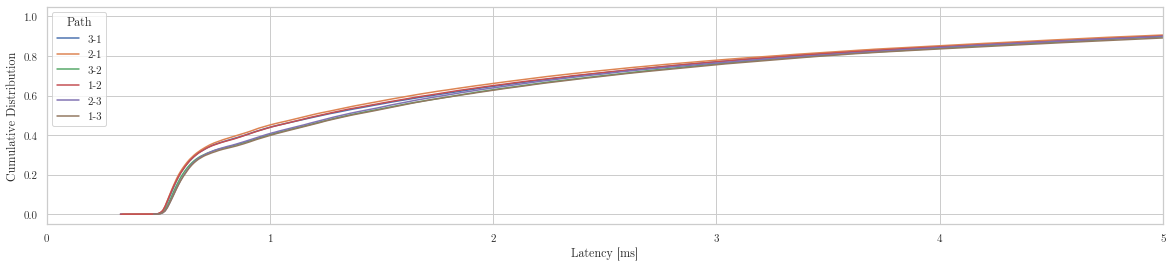

In [18]:
ax_cdf_baseline = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf, hue="Path", ci=None)

#norm = plt.Normalize(0, 80)
#ticks = ["Server", "Satellite"]
#colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax_cdf_baseline.set_xlim(0, 5)
#ax_cdf_paper.get_legend().remove()
#ax_cdf_paper.figure.colorbar(colorbar, ticks=ticks).set_label("Experiment")
ax_cdf_baseline.set_xlabel("Latency [ms]")

(0.0, 100.0)

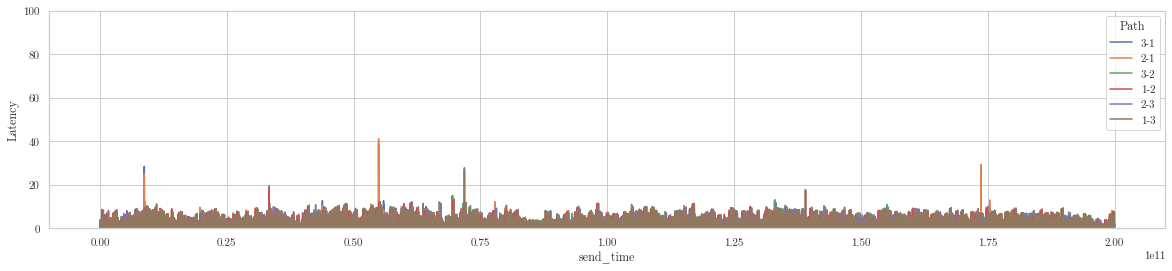

In [19]:
ax_baseline = sns.lineplot(x="send_time", y="Latency", data=df_complete, hue="Path", ci=None)

#norm = plt.Normalize(0, 80)
#ticks = ["Server", "Satellite"]
#colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax_baseline.set_ylim(0, 100)
#ax_cdf_paper.get_legend().remove()
#ax_cdf_paper.figure.colorbar(colorbar, ticks=ticks).set_label("Experiment")
#ax_cdf_baseline.set_xlabel("Latency [ms]")

In [5]:
df_complete["Latency"].mean()

2.254003178506246

In [6]:
df_complete["Latency"].median()

1.37

In [7]:
df_complete["Latency"].quantile(.99)

8.36

In [8]:
df_complete["Latency"].std()

3.868256016091412

In [9]:
df_complete[df_complete["send_time"] > 1.1e11 ]["Latency"].quantile(.99)

8.22

In [38]:
center = df_complete["send_time"].median()
shortened = df_complete[(center - 100*1e9 < df_complete["send_time"]) & (center + 100*1e9 > df_complete["send_time"])].copy()
shortened["send_time"] = shortened["send_time"] - shortened["send_time"].min()
print(shortened["send_time"].max()/1e9)

199.048934656


In [39]:
shortened["Latency"].max()

41.06

In [40]:
shortened["latency_r"].max()

5.035

In [41]:
shortened["latency_r_log10"].max()

0.7019994748896369

In [42]:

shortened["t"] = shortened["send_time"] / 1e9

In [43]:

for path in ["1-2", "1-3", "2-3", "2-1", "3-1", "3-2"]:
    ax = sns.lineplot(x="t", y="Latency", data=shortened[(shortened["Path"] == path)], color="#444444", ci=None)
    ax.set_ylabel("Latency [ms]")
    ax.set_xlabel("t [s]")
    ax.set_xlim(0,200)
    ax.set_ylim(-1.9,41.9)
    save_fig(ax, "./graphs/website/baseline/", "baseline-" + path, format=".png")

    ax = sns.lineplot(x="t", y="latency_r", data=shortened[(shortened["Path"] == path)], color="#444444", ci=None)
    ax.set_ylabel("Latency (1s Rolling Mean) [ms]")
    ax.set_xlabel("t [s]")
    ax.set_xlim(0,200)
    ax.set_ylim(-0.9,5.9)
    save_fig(ax, "./graphs/website/baseline/", "baseline-rolling-" + path, format=".png")

    #ax = sns.lineplot(x="t", y="latency_r_log10", data=df_complete[(df_complete["Path"] == path)], color="#444444", ci=None)
    #ax.set_ylabel("log10 Latency (1s Rolling Mean) [ms]")
    #ax.set_xlabel("t [s]")
    #ax.set_xlim(0,200)
    #ax.set_ylim(-0.19,0.79)
    #save_fig(ax, "./graphs/website/baseline/", "baseline-log10-" + path, format=".png")

<Figure size 1440x288 with 0 Axes>